June 29th  
Now try to simulate the Delta7 network using the average recurrent connectivity profile. Unlike the other notebook, this notebook keeps within glomerular connections, but scales them with a different factor compared to between glomerulus connections.

Need to go through and comment, but look at simulate_using_avg_profile_1 for comments

In [216]:
import sys, os, glob
import datetime, time
import pandas as pd
import numpy as np
from numpy import linalg as nla
import scipy.linalg as sla
import numpy.random as nrd

# import scipy.stats as sst

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

gen_fns_dir = os.path.abspath('../shared')
sys.path.append(gen_fns_dir)
from general_file_fns import load_pickle_file, save_pickle_file
import conn_data_analysis_fns as cdaf

curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'
#sd=int((time.time()%1)*(2**31))
# rng = nrd.default_rng(sd)
# print('Seed= ',sd)

In [3]:
data_path = '../delta7_rec_matrices/'
fname = 'delta7_delta7_average_profiles.p'
conn = load_pickle_file(data_path + fname)
print(conn.keys())

dict_keys(['subtype_list', 'neuron_list', 'subtype_idx', 'subtype_boundaries', 'raw_conn_matrix', 'norm_conn_matrix', 'subtype_rec_matrix', 'subtype_avg_input', 'subtype_avg_output', 'left_glom_list', 'right_glom_list', 'left_glom_idx', 'right_glom_idx', 'left_glom_rec_matrix', 'left_glom_avg_input', 'left_glom_avg_output', 'right_glom_rec_matrix', 'right_glom_avg_input', 'right_glom_avg_output', 'glom_avg_input', 'glom_avg_output', 'n_gloms'])


In [4]:
n_gloms = conn['n_gloms']
glom_avg_input = conn['glom_avg_input']
glom_avg_output = conn['glom_avg_output']

In [5]:
glom_avg_input

array([0.15486901, 0.15601156, 0.11619277, 0.08521092, 0.13174347,
       0.08732954, 0.11803541, 0.15060732])

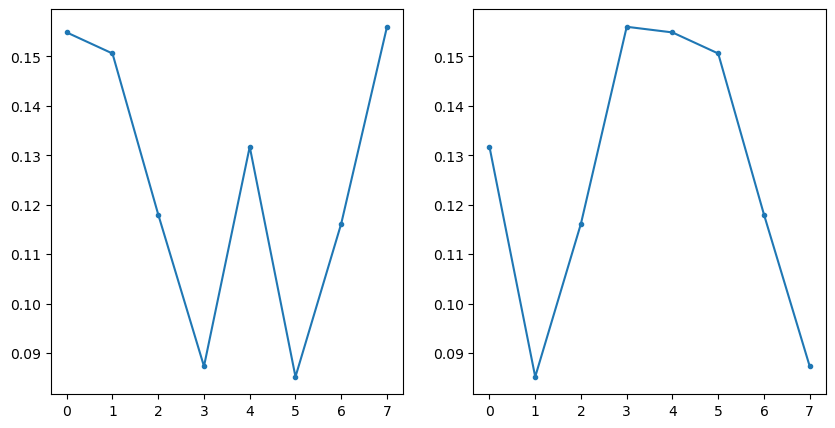

In [6]:
first_col = np.roll(glom_avg_output, -4)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(glom_avg_output, marker='.')
ax[1].plot(first_col, marker='.')

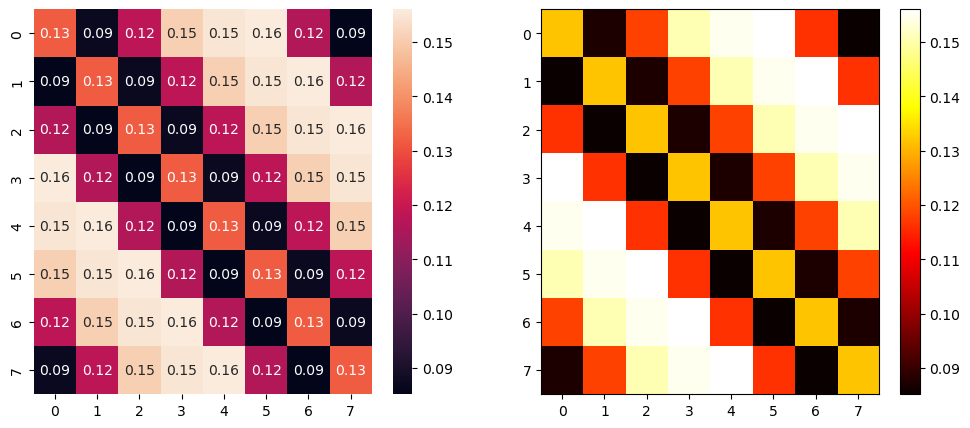

In [7]:
W = sla.circulant(first_col)

fig, ax = plt.subplots(1,2,figsize=(12, 5))
sns.heatmap(W, cmap="rocket", annot=True, fmt=".2f", ax=ax[0])
# ax[0].invert_yaxis()
p = ax[1].imshow(W, aspect='auto', interpolation='nearest', cmap='hot')
fig.colorbar(p, ax=ax[1])



In [8]:
np.allclose(W[:,0], first_col)

True

In [9]:
def relu(x):
    '''Returns 0 if x<0 and x otherwise'''
    return np.maximum(x, 0)

def simulate_network(W, b, x0, time_to_run, dt):
    '''Simulate the network using Euler's method.
    Inputs:
    W:             N x N connectivity matrix
    x0:            N-dimensional initial condition
    time_to_run    how long to simulate for
    dt             simulation step size
    
    Returns an n_times x N matrix containing the simulated system. Note
    that each row is a time point and each column a neuron. 
    '''
    
    n_steps = np.round(time_to_run / dt).astype(int)
    N = W.shape[0] # Number of neurons
    
    # We'll store outputs here
    x = np.zeros((n_steps + 1, N))
    x[0] = np.array(x0)
    
    for i in range(1, n_steps + 1):
        x[i] = x[i-1] + dt * (-x[i-1] + relu(W @ x[i-1] + b))
    
    t = dt * np.arange(n_steps + 1) # Make the time points too for plotting
    return x, t
    

In [10]:
np.diagonal(W)

array([0.13174347, 0.13174347, 0.13174347, 0.13174347, 0.13174347,
       0.13174347, 0.13174347, 0.13174347])

/tmp/ipykernel_2163837/2165428618.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


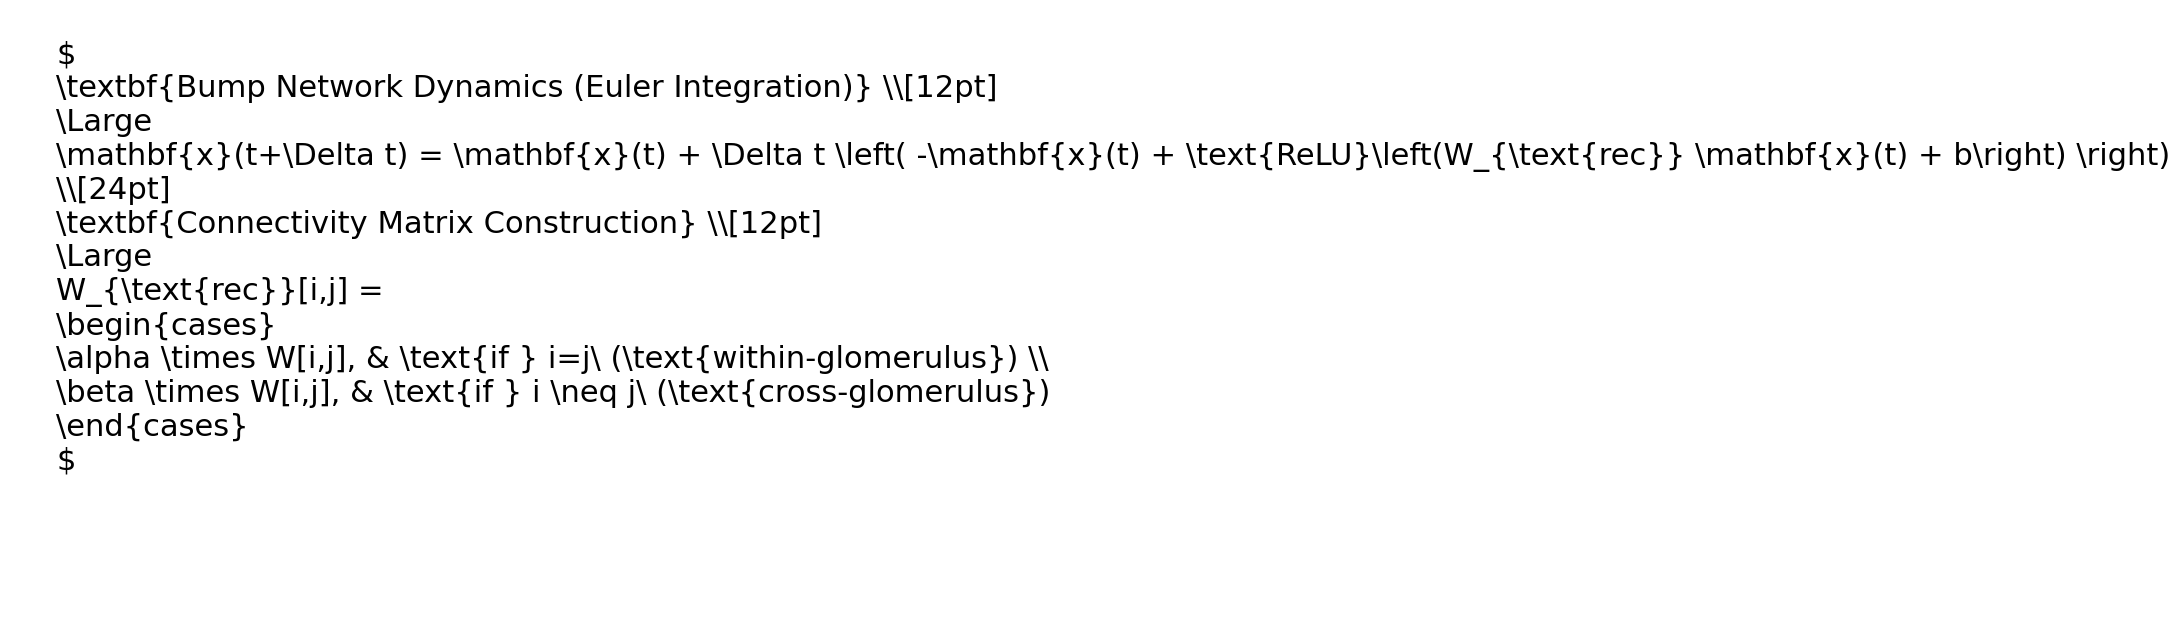

In [277]:
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')  # Hide axes

# Your equations, with $...$ for math mode
equation_text = r"""
\textbf{Bump Network Dynamics (Euler Integration)} \\[12pt]
\Large
\mathbf{x}(t+\Delta t) = \mathbf{x}(t) + \Delta t \left( -\mathbf{x}(t) + \text{ReLU}\left(W_{\text{rec}} \mathbf{x}(t) + b\right) \right)
\\[24pt]
\textbf{Connectivity Matrix Construction} \\[12pt]
\Large
W_{\text{rec}}[i,j] =
\begin{cases}
\alpha \times W[i,j], & \text{if } i=j\ (\text{within-glomerulus}) \\
\beta \times W[i,j], & \text{if } i \neq j\ (\text{cross-glomerulus})
\end{cases}
"""

# Render LaTeX
ax.text(0.05, 0.95, f"${equation_text}$", fontsize=22, va='top', ha='left')

# Save to SVG
plt.tight_layout()
plt.savefig('network_equations.svg', format='svg', bbox_inches='tight')
plt.show()


In [202]:
# alpha converts within glomerulus connection counts to strength, while beta does
# the same for cross glomerular connections. b is a background bias or excitability
alpha = -3
beta = -7
b = 20

W_rec = beta * W
np.fill_diagonal(W_rec, alpha*np.diagonal(W).copy())

In [203]:
# beta = -8, b=25 gives 3 glom wide bump
x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
x0 = np.roll(x0, 3)
time_to_run = 100.
dt = 0.05

x, t = simulate_network(W_rec, b, x0, time_to_run, dt)

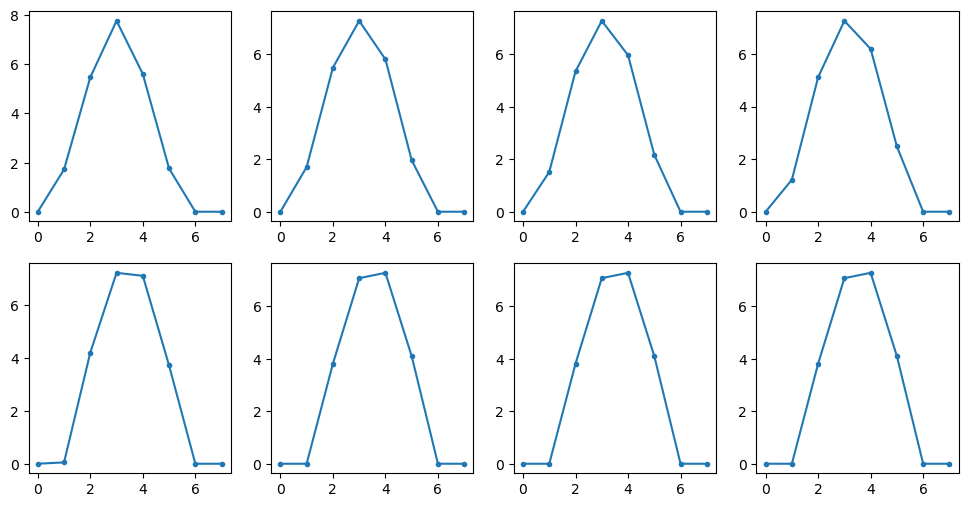

In [204]:
# time_points = np.array([0, 1, 2, 3, 4, 5, 6, 6.9])
time_points = np.array([2, 10, 20, 30, 50, 80, 90, 99])
time_idx = np.round(time_points/dt).astype(int)
fig, axes = plt.subplots(2,4,figsize=(12,6))
for tid, ax in zip(time_idx, axes.flatten()):
    ax.plot(x[tid], marker='.')
    

In [213]:
x.shape

(2001, 8)

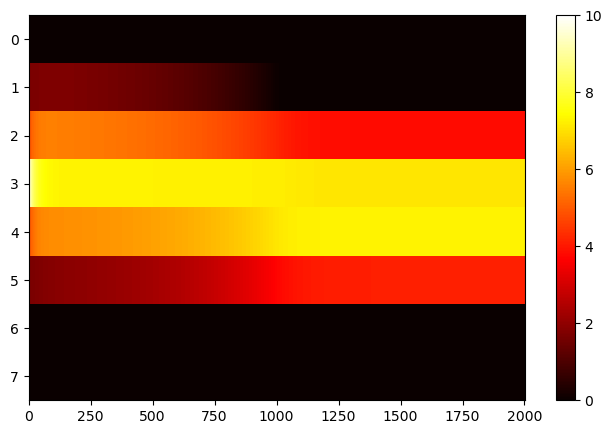

In [214]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
# sns.heatmap(x.T, cmap="rocket")
p = ax.imshow(x.T, aspect='auto', interpolation='nearest', cmap='hot')
fig.colorbar(p, ax=ax)


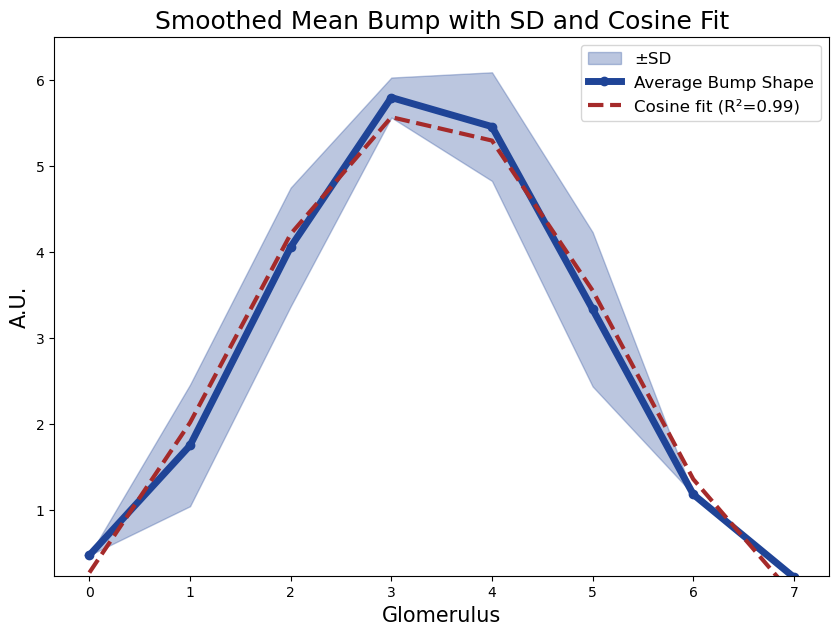

Fit parameters: Amplitude = -2.88, Phase = -0.52 rad, Offset = 2.78
R² of the fit: 0.990


In [240]:
# Define colors
deep_blue = "#1f4497"    # For mean bump
cosine_fit_color = "#A52A2A"  # Different color for cosine fit

# Step 1: Define cosine function
def cosine_func(x, amplitude, phase, offset):
    return amplitude * np.cos(2 * np.pi * (x / 8) - phase) + offset

# Step 2: Compute mean and SD
mean_bump_raw = np.nanmean(x, axis=0)
sd_bump = np.nanstd(x, axis=0)  # SD of raw data
x_vals = np.arange(8)

# Step 3: Smooth the mean bump
mean_bump = gaussian_filter1d(mean_bump_raw, sigma=1)  # Smooth with small sigma (you can adjust)

# Step 4: Fit cosine to smoothed mean bump
initial_guess = [1, 0, 0]
params, _ = curve_fit(cosine_func, x_vals, mean_bump, p0=initial_guess)
fitted_curve = cosine_func(x_vals, *params)

# Step 5: Quantify fit (R²)
r2 = r2_score(mean_bump, fitted_curve)

# Step 6: Plot everything
fig, ax = plt.subplots(figsize=(10, 7))

# Plot smoothed mean ± SD shaded area
ax.fill_between(x_vals, mean_bump - sd_bump, mean_bump + sd_bump,
                color=deep_blue, alpha=0.3, label='±SD')

# Plot smoothed mean bump
ax.plot(x_vals, mean_bump, 'o-', color=deep_blue, linewidth=5, label='Average Bump Shape')

# Plot cosine fit
ax.plot(x_vals, fitted_curve, '--', color=cosine_fit_color, linewidth=3, label=f'Cosine fit (R²={r2:.2f})')

# Labels, title, legend
ax.set_xlabel('Glomerulus', fontsize=15)
ax.set_ylabel('A.U.', fontsize=15)
ax.set_title('Smoothed Mean Bump with SD and Cosine Fit', fontsize=18)
ax.legend(fontsize=12)
ax.set_ylim(0.24,6.5)
#plt.savefig('Bump_shape_deta7_bump_simulaton_smooth.svg', format='svg')
plt.show()

# Print fit parameters
print(f"Fit parameters: Amplitude = {params[0]:.2f}, Phase = {params[1]:.2f} rad, Offset = {params[2]:.2f}")
print(f"R² of the fit: {r2:.3f}")

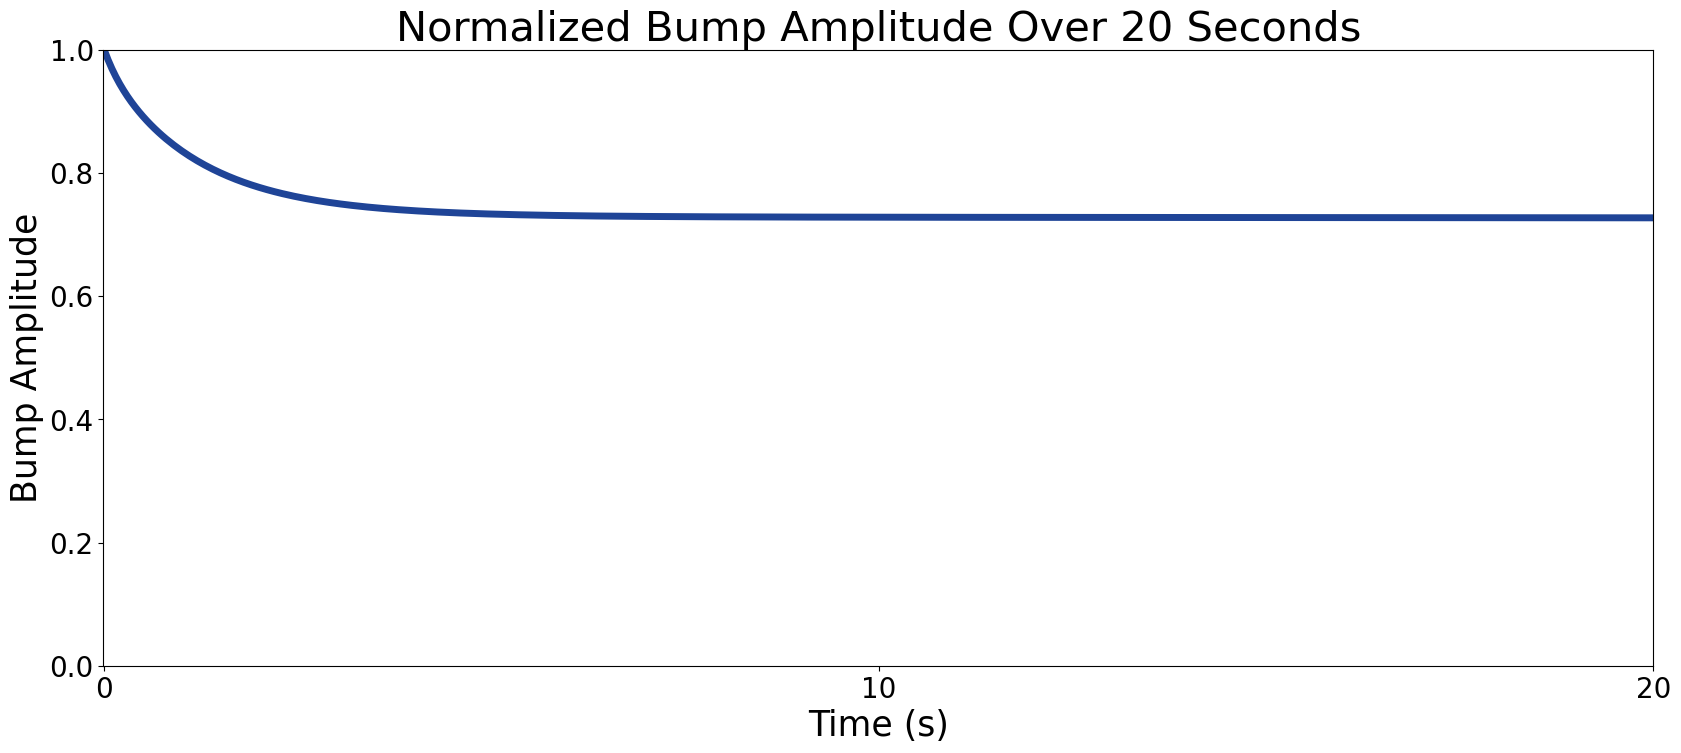

In [210]:

# Step 1: Compute bump amplitude
bump_amplitude = np.nanmax(x[:2000], axis=1) - np.nanmin(x[:2000], axis=1)  # Use first 2000 frames
# Step 2: Normalize amplitude to its value at t = 0
normalized_bump_amplitude = bump_amplitude / bump_amplitude[0]

# Step 3: Create time array (0 to 100 seconds)
time_array = np.linspace(0, 100, len(normalized_bump_amplitude))


# Step 4: Set up plot (your style)
palette = sns.color_palette("tab20b_r", 1)  # Only 1 line
deep_blue = "#1f4497"
plt.figure(figsize=(20, 8))

# Plot normalized, smoothed
plt.plot(
    time_array,
    gaussian_filter1d(normalized_bump_amplitude, sigma=0.1),  # Smoothing
    linewidth=5,
    color=deep_blue
)

# Custom x-ticks every 10 seconds
plt.xticks(
    ticks=np.arange(0, 101, 10),
    labels=np.arange(0, 101, 10, dtype=int),
    fontsize=20
)
plt.yticks(fontsize=20)
plt.xlim(-0.01, 20)
plt.ylim(0, 1)

# Labels and title
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title('Normalized Bump Amplitude Over 20 Seconds', fontsize=30)
#plt.savefig('Bump_amplitude_deta7_bump_simulaton_smooth.svg', format='svg')
plt.show()

In [153]:
W_rec @ x[-1] + b

array([-2.99800389, -0.31332206,  3.81634157,  7.07997584,  7.28397354,
        4.10615564, -0.24277874, -2.99309271])

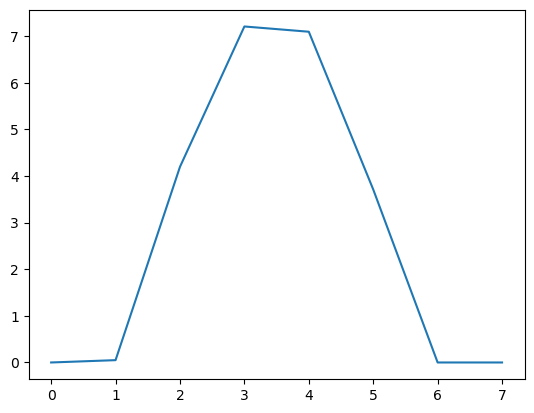

In [155]:
plt.plot(x[1000])

In [156]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [157]:
def calculate_fwhm(vec):
    vec = np.array(vec)
    if np.all(np.isnan(vec)) or np.max(vec) == 0:
        return np.nan

    peak = np.max(vec)
    half_max = peak / 2

    above_half = np.where(vec >= half_max)[0]
    if len(above_half) == 0:
        return np.nan

    return len(above_half) * 45  # each ROI is 45°

In [158]:
calculate_fwhm(x[1500])

180

In [115]:
fwhms = np.array([calculate_fwhm(frame) for frame in x])
mean_fwhm = np.nanmean(fwhms)

In [116]:
mean_fwhm

156.16191904047977

In [24]:
x

array([[0.00000000e+00, 2.00000000e+00, 5.00000000e+00, ...,
        2.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.90000000e+00, 4.75000000e+00, ...,
        1.90000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.80500000e+00, 4.51250000e+00, ...,
        1.80500000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.40005468e-02, 1.80910049e-01, 2.52076324e-01, ...,
        5.30537068e-02, 5.90891628e-41, 0.00000000e+00],
       [7.40007117e-02, 1.80910210e-01, 2.52076398e-01, ...,
        5.30535420e-02, 5.61347047e-41, 0.00000000e+00],
       [7.40008759e-02, 1.80910370e-01, 2.52076472e-01, ...,
        5.30533780e-02, 5.33279694e-41, 0.00000000e+00]])

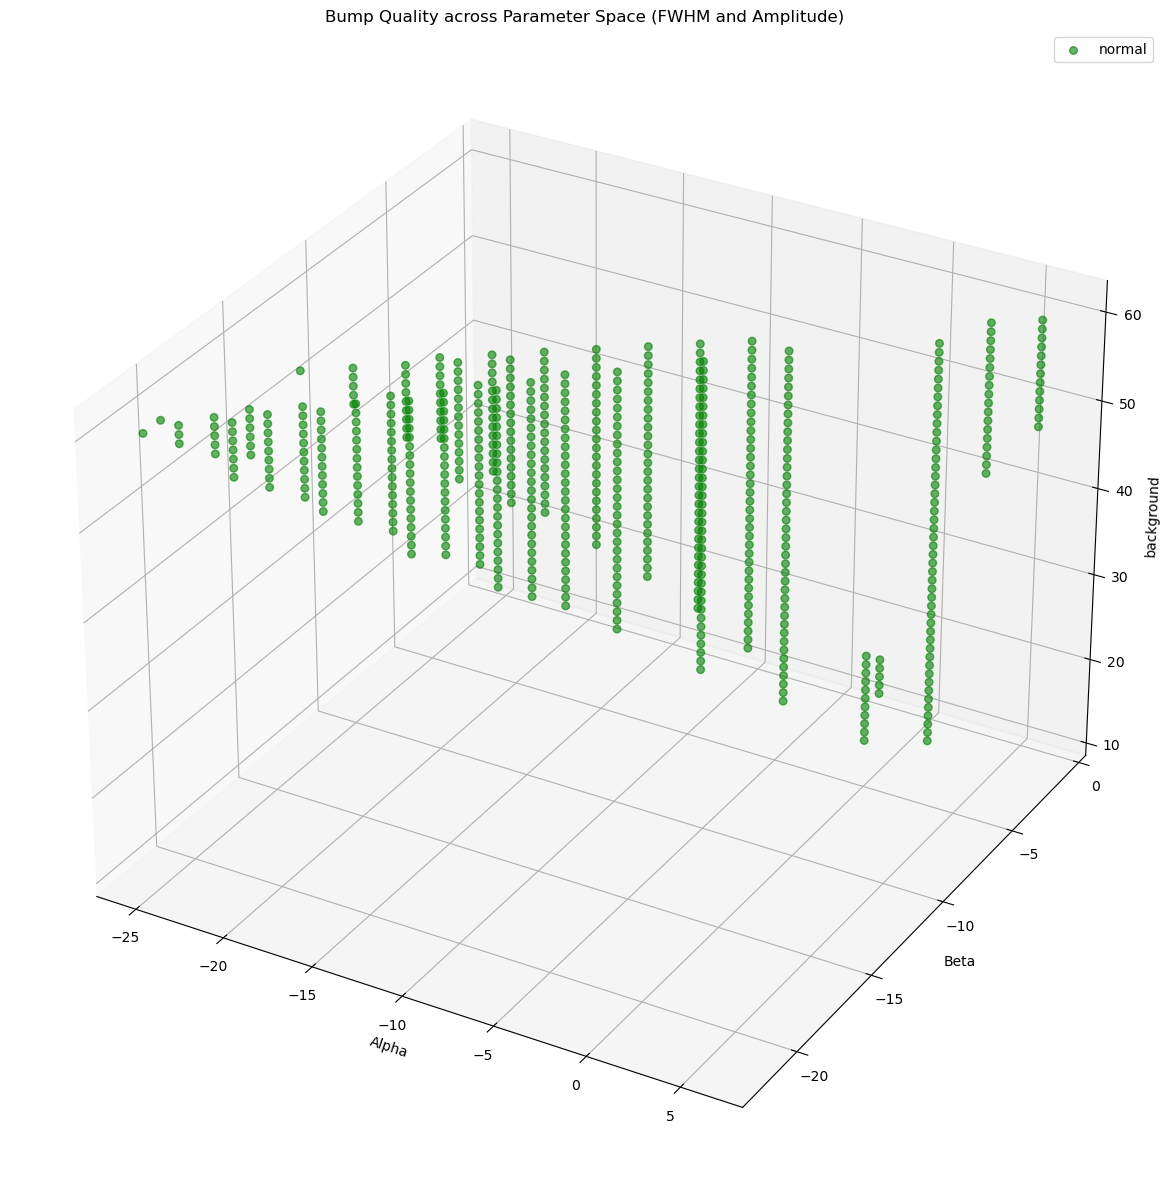

In [179]:
# Initialize constants
x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
x0 = np.roll(x0, 3)
time_to_run = 100.0  # shorter run to reduce computational load
dt = 0.1


# Reduce the scan for demonstration (due to performance constraints)
alphas = range(-25,26 , 1)
betas = range(-25, 1, 1)
bs = range(0, 61, 1)

results = []

for alpha in alphas:
    for beta in betas:
        for b in bs:
            W_rec = beta * W
            np.fill_diagonal(W_rec, alpha * np.diagonal(W).copy())
            x, t = simulate_network(W_rec, b, x0, time_to_run, dt)
            fwhms = np.array([calculate_fwhm(frame) for frame in x])
            mean_fwhm = np.nanmean(fwhms[500:1500])

            if mean_fwhm < 90:
                category = 'extreme narrow bump'
            elif np.isnan(mean_fwhm):
                category = 'no bump'
            elif mean_fwhm < 150:
                category = 'narrow'
            elif mean_fwhm < 220:
                # Check bump amplitude if it's in 'normal' category
                bump_amplitude = np.max(x, axis=1) - np.min(x, axis=1)
                avg_bump_amplitude = np.mean(bump_amplitude[500:1500])
                if avg_bump_amplitude < 7:
                    category = 'normal decay'
                else:
                    category = 'normal'
            else:
                category = 'wide'
            results.append((alpha, beta, b, category))

# Plot
#category_colors = {'no bump': 'gray', 'narrow': 'blue', 'normal': 'green', 'wide': 'red', 'normal decay': 'purple'}

# Only plot 'normal' category
category_colors = {'normal': 'green'}

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

subset = np.array([r for r in results if r[3] == 'normal'])
if subset.size > 0:
    subset = np.array(subset)
    ax.scatter(subset[:, 0].astype(float), subset[:, 1].astype(float), subset[:, 2].astype(float),
               label='normal', color=category_colors['normal'], alpha=0.6, s=30)


#for cat, color in category_colors.items():
    #subset = np.array([r for r in results if r[3] == cat])
    #if subset.size > 0:
        #subset = np.array(subset)
        #ax.scatter(subset[:, 0].astype(float), subset[:, 1].astype(float), subset[:, 2].astype(float),
                   #label=cat, color=color, alpha=0.6, s=30)

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('background')
ax.set_title('Bump Quality across Parameter Space (FWHM and Amplitude)')
ax.legend()
plt.tight_layout()
plt.show()

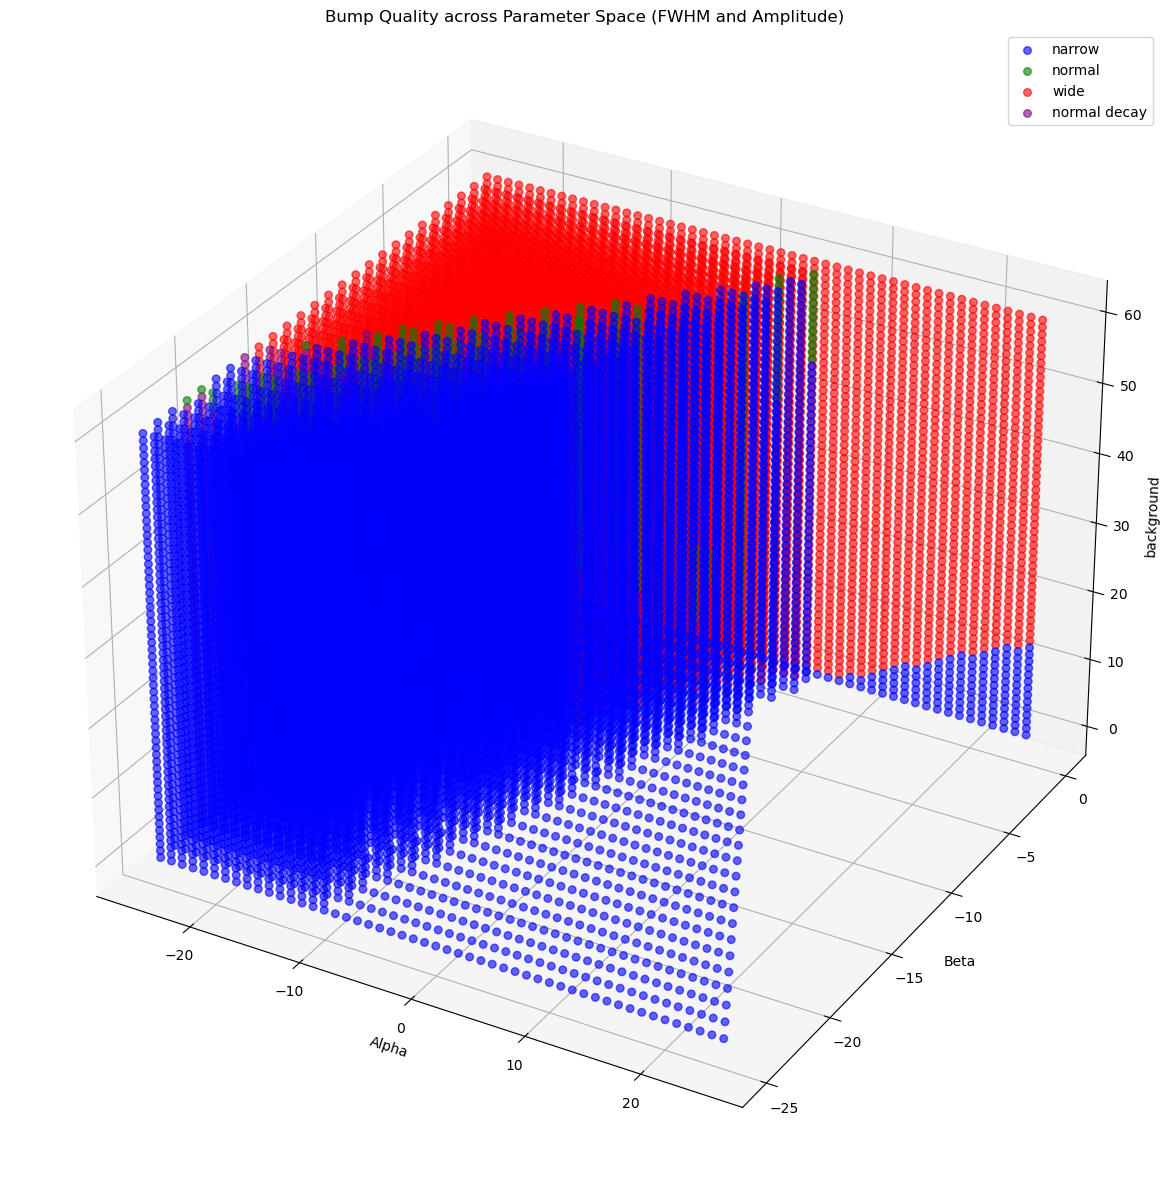

In [180]:
# Plot
category_colors = {'no bump': 'gray', 'narrow': 'blue', 'normal': 'green', 'wide': 'red', 'normal decay': 'purple','extreme narrow':'orange'}

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')




for cat, color in category_colors.items():
    subset = np.array([r for r in results if r[3] == cat])
    if subset.size > 0:
        subset = np.array(subset)
        ax.scatter(subset[:, 0].astype(float), subset[:, 1].astype(float), subset[:, 2].astype(float),
                   label=cat, color=color, alpha=0.6, s=30)

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('background')
ax.set_title('Bump Quality across Parameter Space (FWHM and Amplitude)')
ax.legend()
plt.tight_layout()
plt.show()

In [184]:
# Convert the results list into a DataFrame
results_df = pd.DataFrame(results, columns=["alpha", "beta", "b", "category"])
# Save to CSV for future loading
results_path = "/home/tianhaoqiu/Documents/GitHub/simulation_delta7_bump_results.csv"
#results_df.to_csv(results_path, index=False)


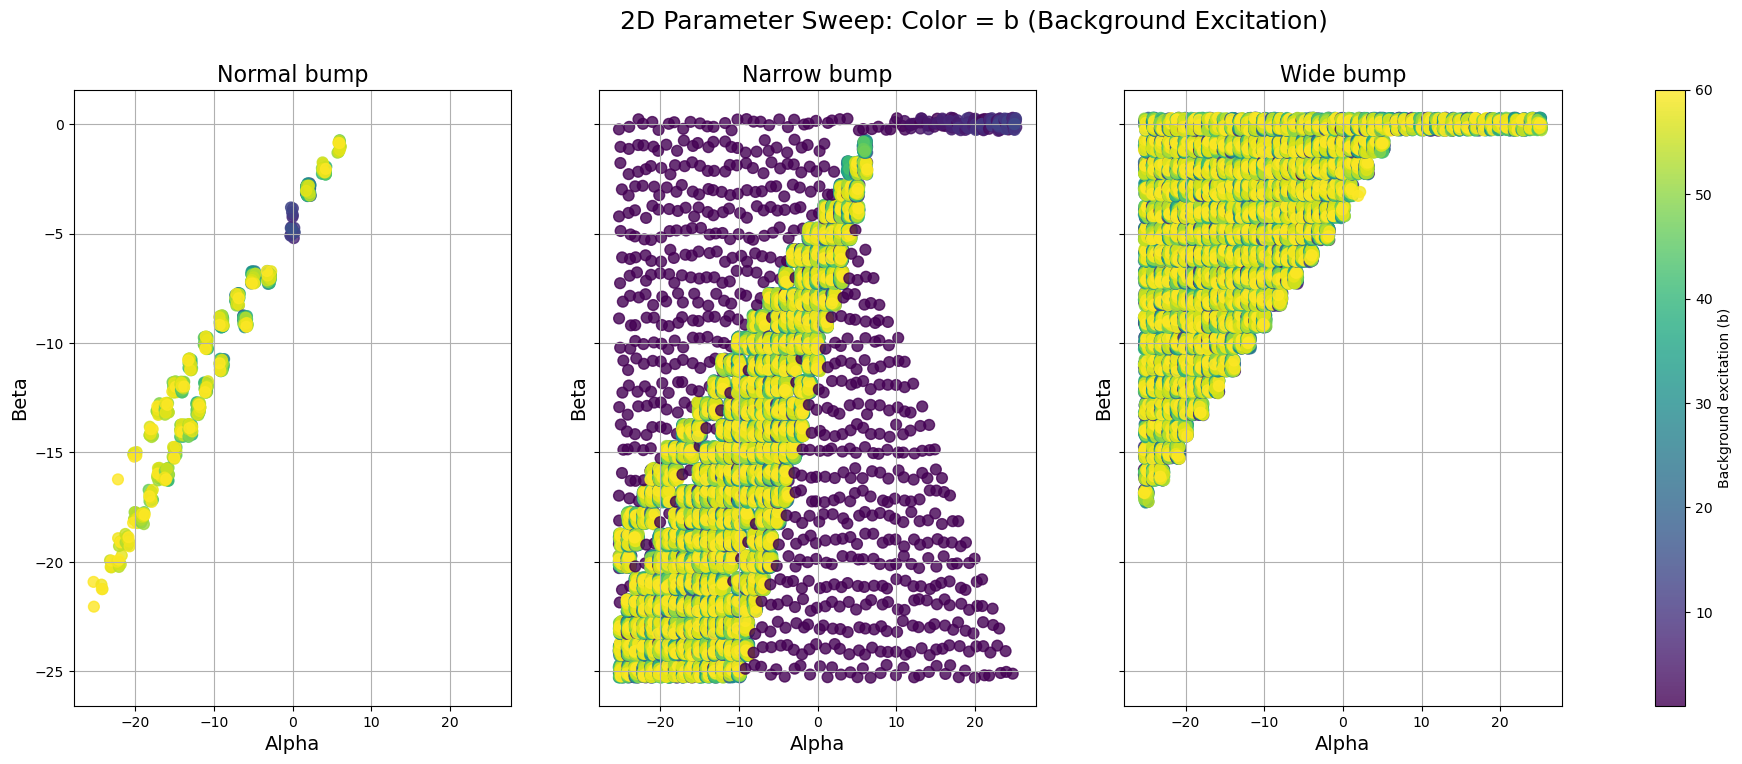

In [181]:
# Assume `results` is available in context
# Convert to DataFrame
df = pd.DataFrame(results, columns=["alpha", "beta", "b", "category"])

# Filter for selected categories
selected_categories = ["normal", "narrow", "wide"]
category_colors = {"normal": "green", "narrow": "blue", "wide": "red"}

# Jitter strength
jitter_strength = 0.3

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

for ax, cat in zip(axes, selected_categories):
    subset = df[df["category"] == cat].copy()

    # Apply jitter to alpha and beta
    alpha_jittered = subset["alpha"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    beta_jittered = subset["beta"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    b_vals = subset["b"]

    sc = ax.scatter(alpha_jittered, beta_jittered, c=b_vals, cmap="viridis", alpha=0.8, s=60)
    ax.set_title(f"{cat.capitalize()} bump", fontsize=16)
    ax.set_xlabel("Alpha", fontsize=14)
    ax.set_ylabel("Beta", fontsize=14)
    ax.grid(True)

fig.colorbar(sc, ax=axes.ravel().tolist(), label="Background excitation (b)")
fig.suptitle("2D Parameter Sweep: Color = b (Background Excitation)", fontsize=18)
plt.show()

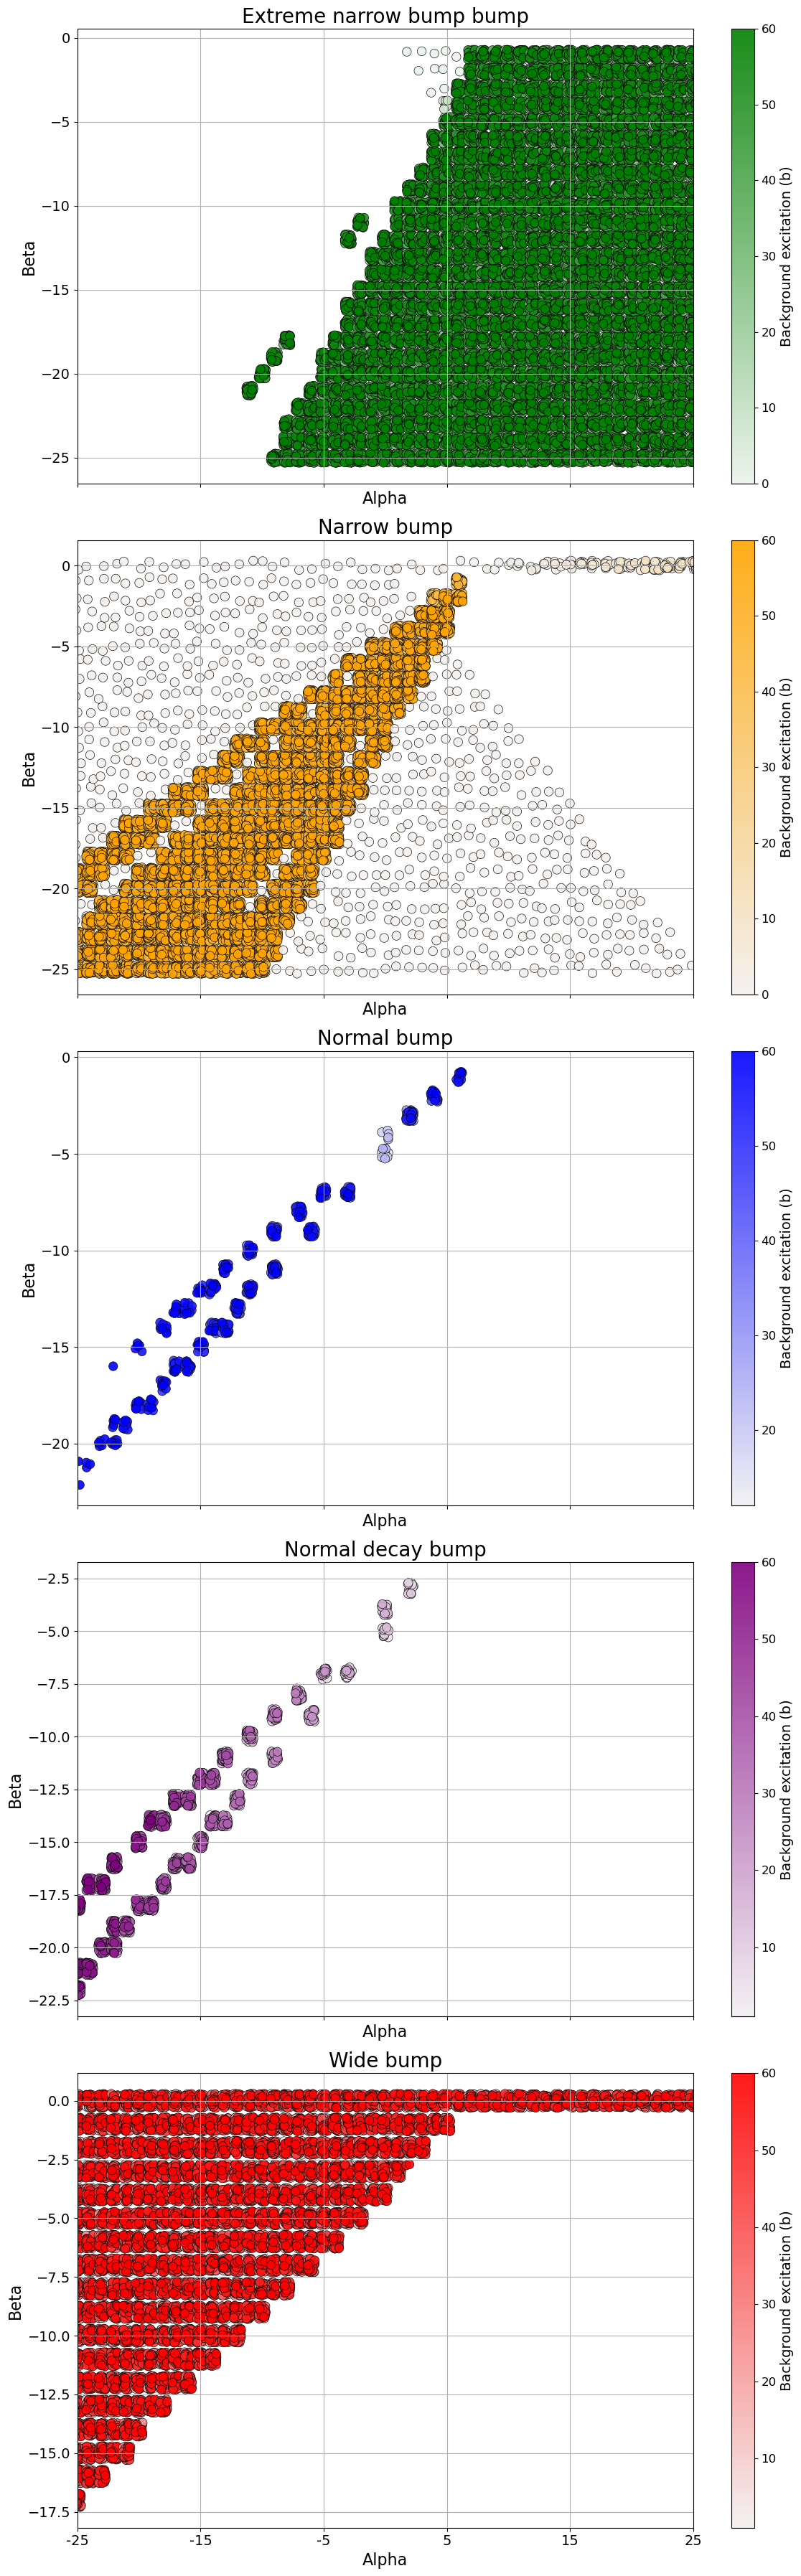

In [200]:
# Load data
df = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/simulation_delta7_bump_results.csv')
# Categories and colormaps
category_list = ["extreme narrow bump", "narrow", "normal", "normal decay", "wide"]
category_cmaps = {
    "extreme narrow bump": sns.color_palette("light:green", as_cmap=True),
    "narrow": sns.color_palette("light:orange", as_cmap=True),
    "normal": sns.color_palette("light:b", as_cmap=True),
    "normal decay": sns.color_palette("light:purple", as_cmap=True),
    "wide": sns.color_palette("light:red", as_cmap=True)
}

# Jitter strength
jitter_strength = 0.3

# Plot setup
fig, axes = plt.subplots(len(category_list), 1, figsize=(12, 36), sharex=True)

# Set global alpha tick range
alpha_min, alpha_max = -25, 25
x_ticks = np.arange(alpha_min, alpha_max + 1, 10)

for ax, cat in zip(axes, category_list):
    subset = df[df["category"] == cat].copy()
    if subset.empty:
        ax.set_visible(False)
        continue

    # Apply jitter
    alpha_jittered = subset["alpha"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    beta_jittered = subset["beta"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    b_vals = subset["b"]

    sc = ax.scatter(alpha_jittered, beta_jittered, c=b_vals,
                    cmap=category_cmaps[cat], alpha=0.9, s=80, edgecolor='k', linewidth=0.5)

    # Labels and formatting for each plot
    ax.set_title(f"{cat.capitalize()} bump", fontsize=20)
    ax.set_ylabel("Beta", fontsize=16)
    ax.set_xlabel("Alpha", fontsize=16)
    ax.set_xlim(alpha_min, alpha_max)
    ax.set_xticks(x_ticks)  # ✅ Ensure ticks appear on all subplots
    ax.set_xticklabels(x_ticks, fontsize=14)  # ✅ Tick labels on all subplots
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

    # Add colorbar per subplot
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("Background excitation (b)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig('simulation_delta7_bump', format ='png')
plt.show()

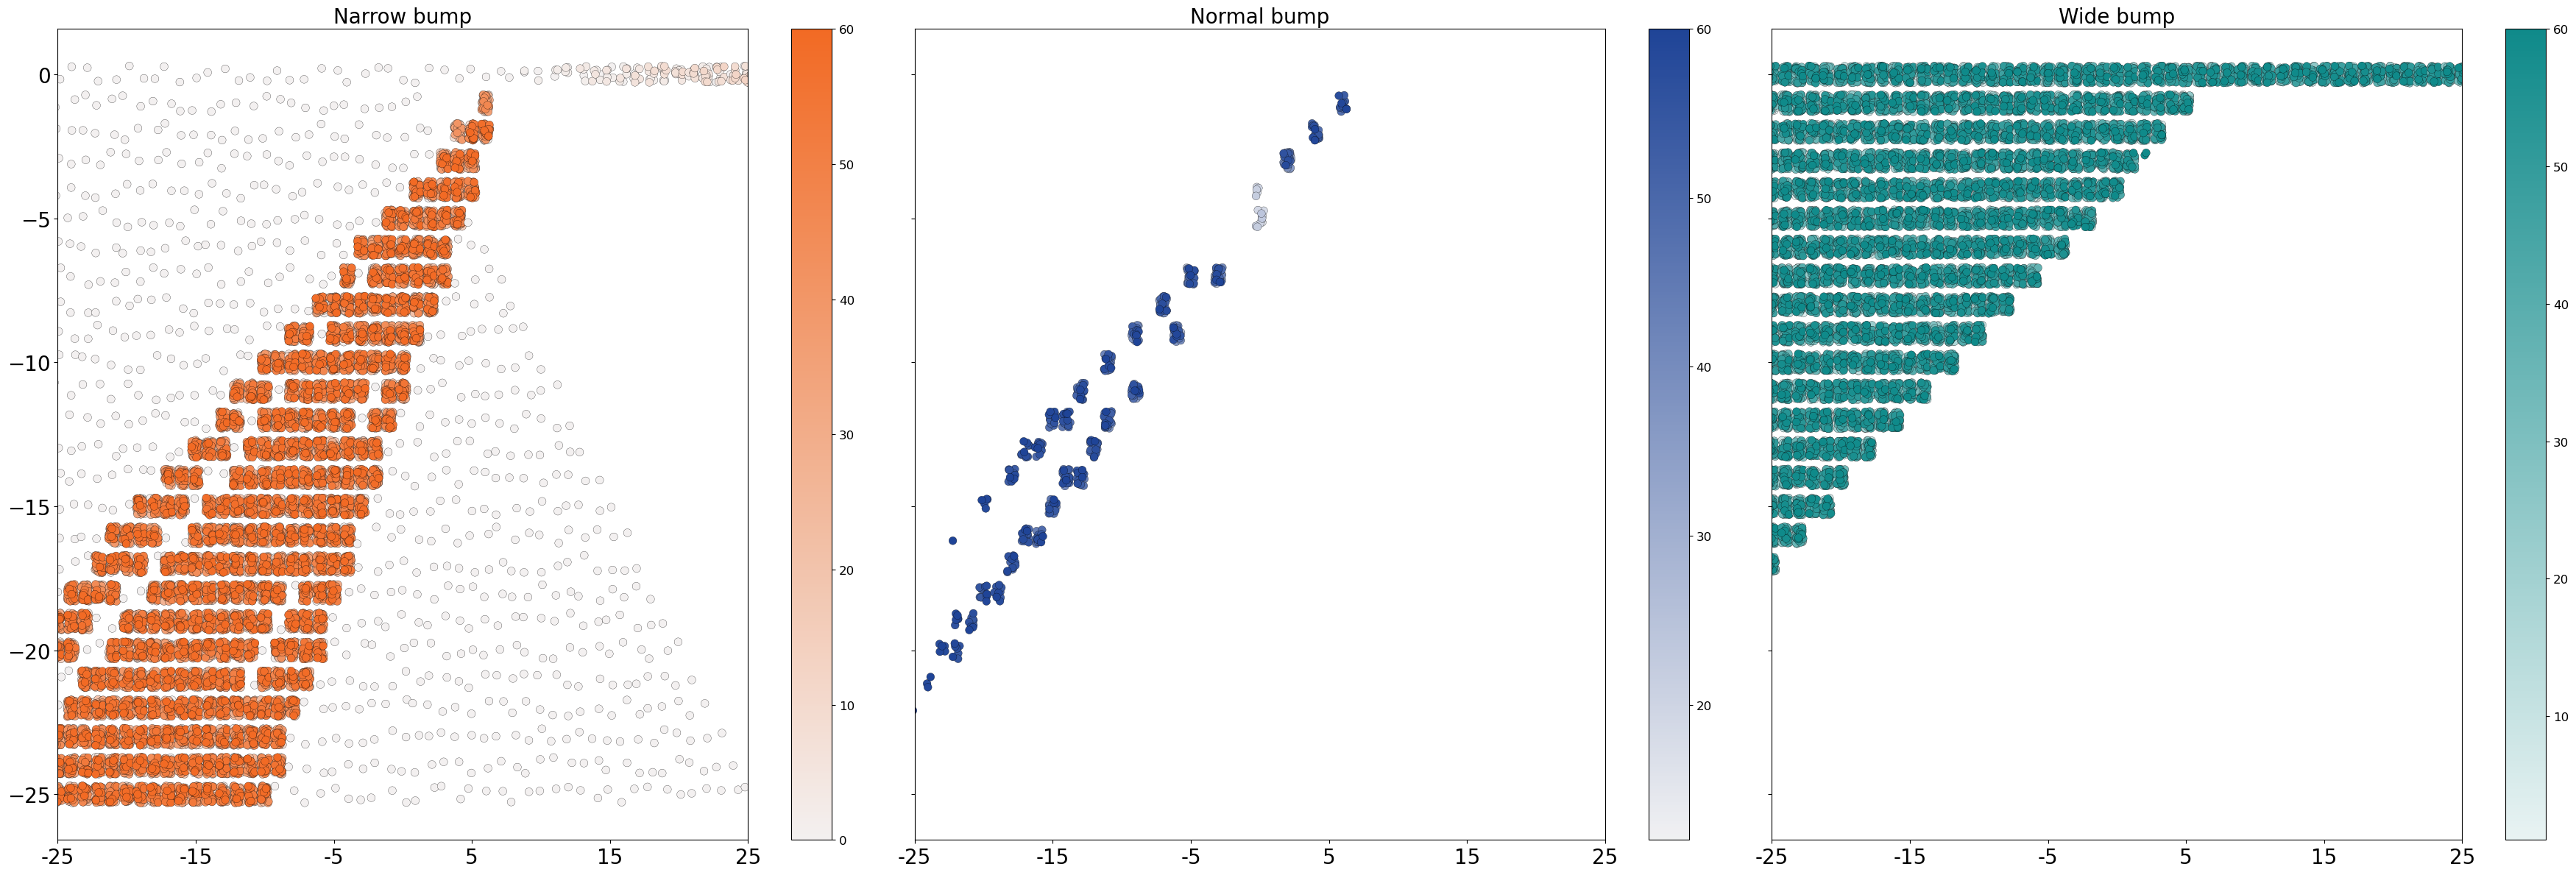

In [273]:
# Load data
df = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/simulation_delta7_bump_results.csv')

# Selected categories and their color maps
selected_categories = ["narrow", "normal", "wide"]
category_cmaps = {
    "narrow": sns.light_palette("#f26a24", as_cmap=True),
    "normal": sns.light_palette("#1f4497", as_cmap=True),  
    "wide": sns.light_palette("#0f8a8a", as_cmap=True)
}

# Jitter strength
jitter_strength = 0.3

# Plot setup
fig, axes = plt.subplots(1, len(selected_categories), figsize=(36, 12), sharey=True)

# Set global alpha tick range
alpha_min, alpha_max = -25, 25
x_ticks = np.arange(alpha_min, alpha_max + 1, 10)

for ax, cat in zip(axes, selected_categories):
    subset = df[df["category"] == cat].copy()
    if subset.empty:
        ax.set_visible(False)
        continue

    # Apply jitter
    alpha_jittered = subset["alpha"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    beta_jittered = subset["beta"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    b_vals = subset["b"]

    # Color scatter plot using the corresponding colormap
    sc = ax.scatter(alpha_jittered, beta_jittered, c=b_vals,
                    cmap=category_cmaps[cat], alpha=1, s=60, edgecolor='k', linewidth=0.2)

    # Colorbar for each plot
    cbar = fig.colorbar(sc, ax=ax)
    #cbar.set_label("Background excitation (b)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Labels and formatting
    ax.set_title(f"{cat.capitalize()} bump", fontsize=20)
    #ax.set_xlabel("Alpha", fontsize=16)
    ax.set_xlim(alpha_min, alpha_max)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    

# Shared y-axis label
#axes[0].set_ylabel("Beta", fontsize=16)

plt.tight_layout()
plt.rcParams['svg.hashsalt'] = 'fixed'  # Optional: makes IDs predictable
plt.rcParams['svg.fonttype'] = 'path'   # Save fonts as paths (optional)
plt.savefig('simulation_delta7_bump_narrow_normal_wide_corrected.eps', format='eps' ,dpi=100)

plt.show()

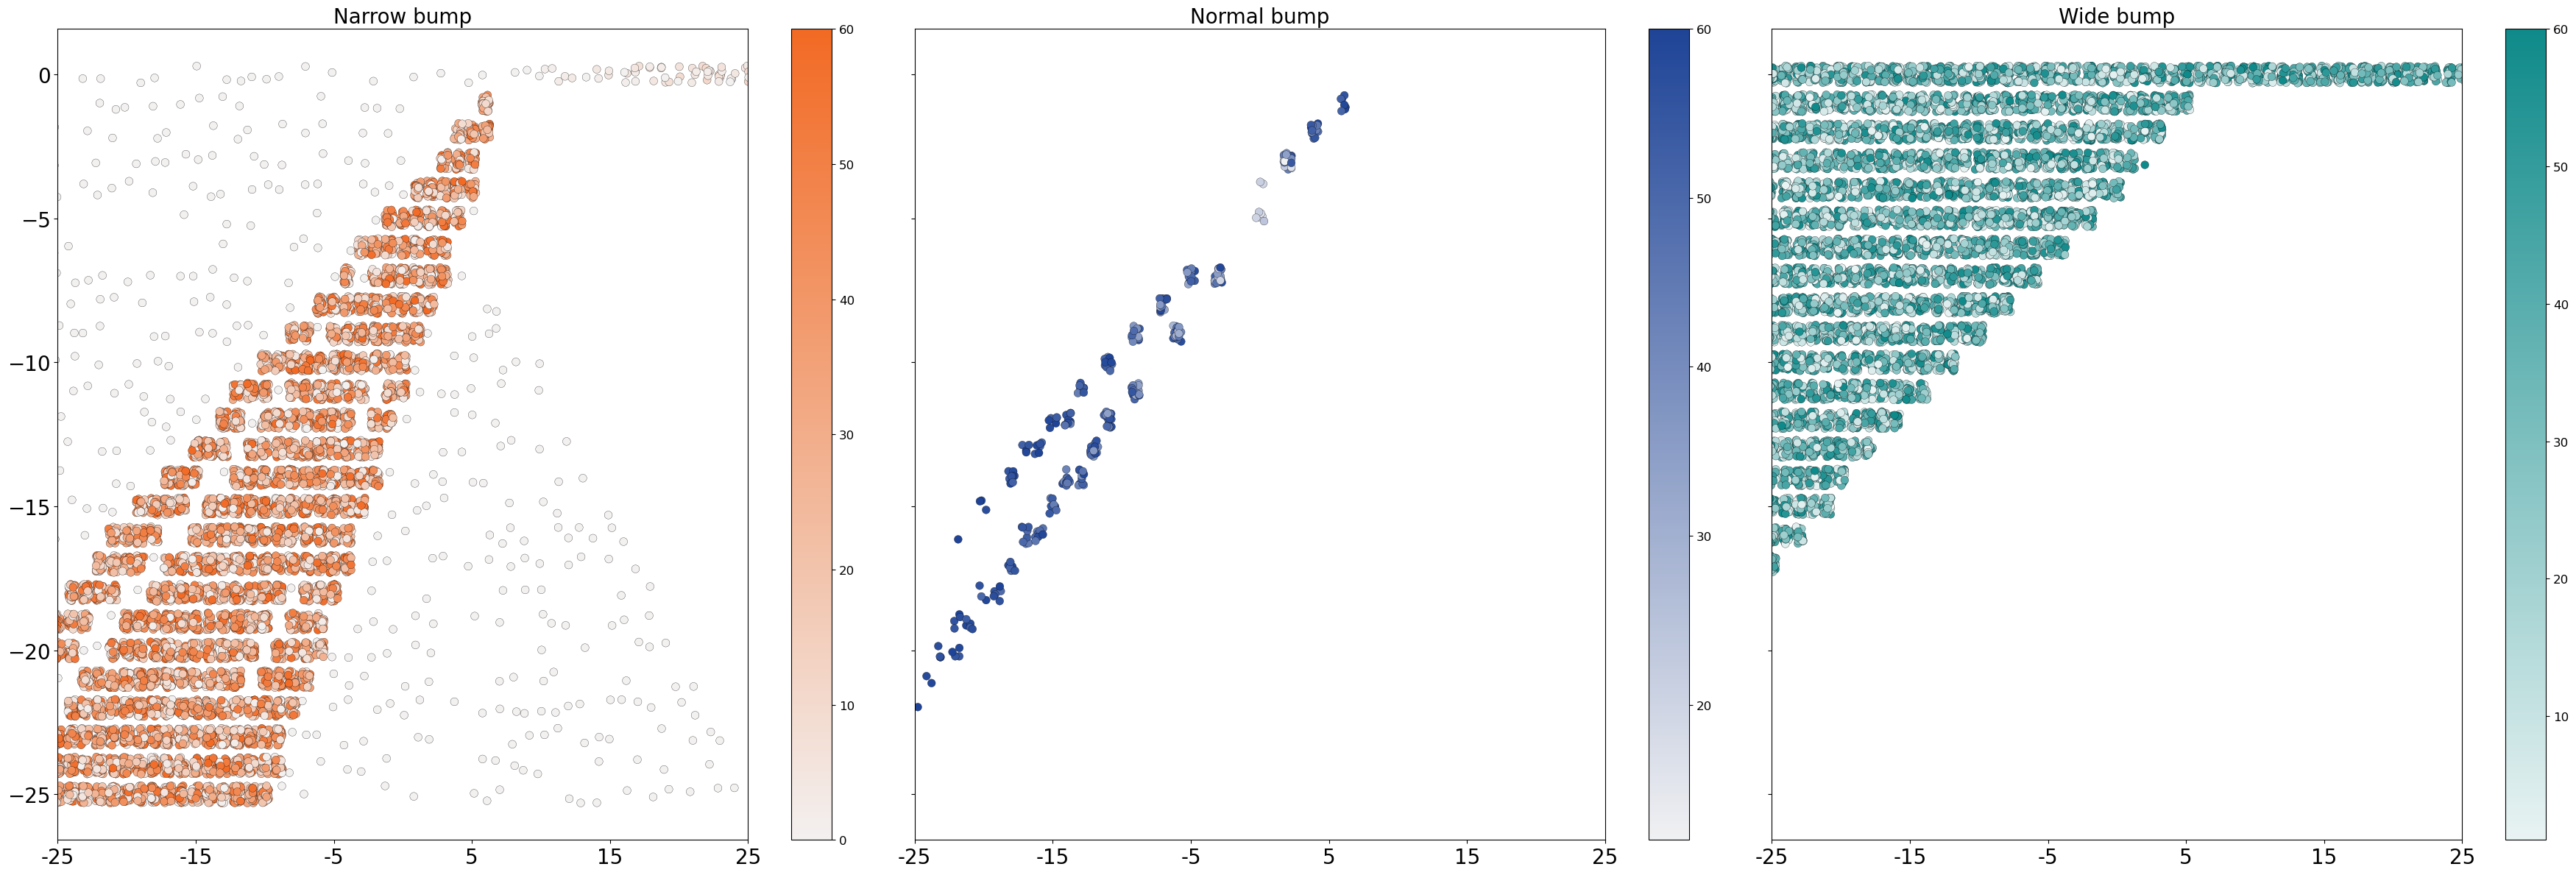

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/simulation_delta7_bump_results.csv')

# Selected categories and their color maps
selected_categories = ["narrow", "normal", "wide"]
category_cmaps = {
    "narrow": sns.light_palette("#f26a24", as_cmap=True),
    "normal": sns.light_palette("#1f4497", as_cmap=True),  
    "wide": sns.light_palette("#0f8a8a", as_cmap=True)
}

# Jitter strength
jitter_strength = 0.3

# Plot setup
fig, axes = plt.subplots(1, len(selected_categories), figsize=(36, 12), sharey=True)

# Set global alpha tick range
alpha_min, alpha_max = -25, 25
x_ticks = np.arange(alpha_min, alpha_max + 1, 10)

for ax, cat in zip(axes, selected_categories):
    subset = df[df["category"] == cat].copy()
    if subset.empty:
        ax.set_visible(False)
        continue

    # 🔥 Subsample 50% to reduce overlapping
    subset = subset.sample(frac=0.5, random_state=42)

    # Apply jitter
    alpha_jittered = subset["alpha"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    beta_jittered = subset["beta"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subset))
    b_vals = subset["b"]

    # Color scatter plot using the corresponding colormap
    sc = ax.scatter(alpha_jittered, beta_jittered, c=b_vals,
                    cmap=category_cmaps[cat], alpha=1, s=60, edgecolor='k', linewidth=0.2)

    # Colorbar for each plot
    cbar = fig.colorbar(sc, ax=ax)
    #cbar.set_label("Background excitation (b)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Labels and formatting
    ax.set_title(f"{cat.capitalize()} bump", fontsize=20)
    ax.set_xlim(alpha_min, alpha_max)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

# Shared y-axis label
# axes[0].set_ylabel("Beta", fontsize=16)

plt.tight_layout()

# SVG/EPS saving options
plt.rcParams['svg.hashsalt'] = 'fixed'  # Optional: makes IDs predictable
plt.rcParams['svg.fonttype'] = 'path'   # Save fonts as paths (optional)

# Save the figure
plt.savefig('simulation_delta7_bump_narrow_normal_wide_corrected.svg', format='svg', dpi=100)

plt.show()


In [127]:
# Convert to DataFrame
df = pd.DataFrame(results, columns=["alpha", "beta", "b", "category"])

# Show the range of parameters for each category
summary = df.groupby("category").agg({
    "alpha": ["min", "max"],
    "beta": ["min", "max"],
    "b": ["min", "max"]
}).reset_index()



In [128]:
summary

category alpha     beta       b    
                         min max  min max min max
0  extreme narrow bump   -11  23  -25  -1   0  58
1               narrow   -25  23  -25  -1   0  58
2               normal   -21  -3  -19  -7  20  58
3         normal decay   -25  -3  -21  -7   2  58
4                 wide   -25   5  -17  -1   2  58

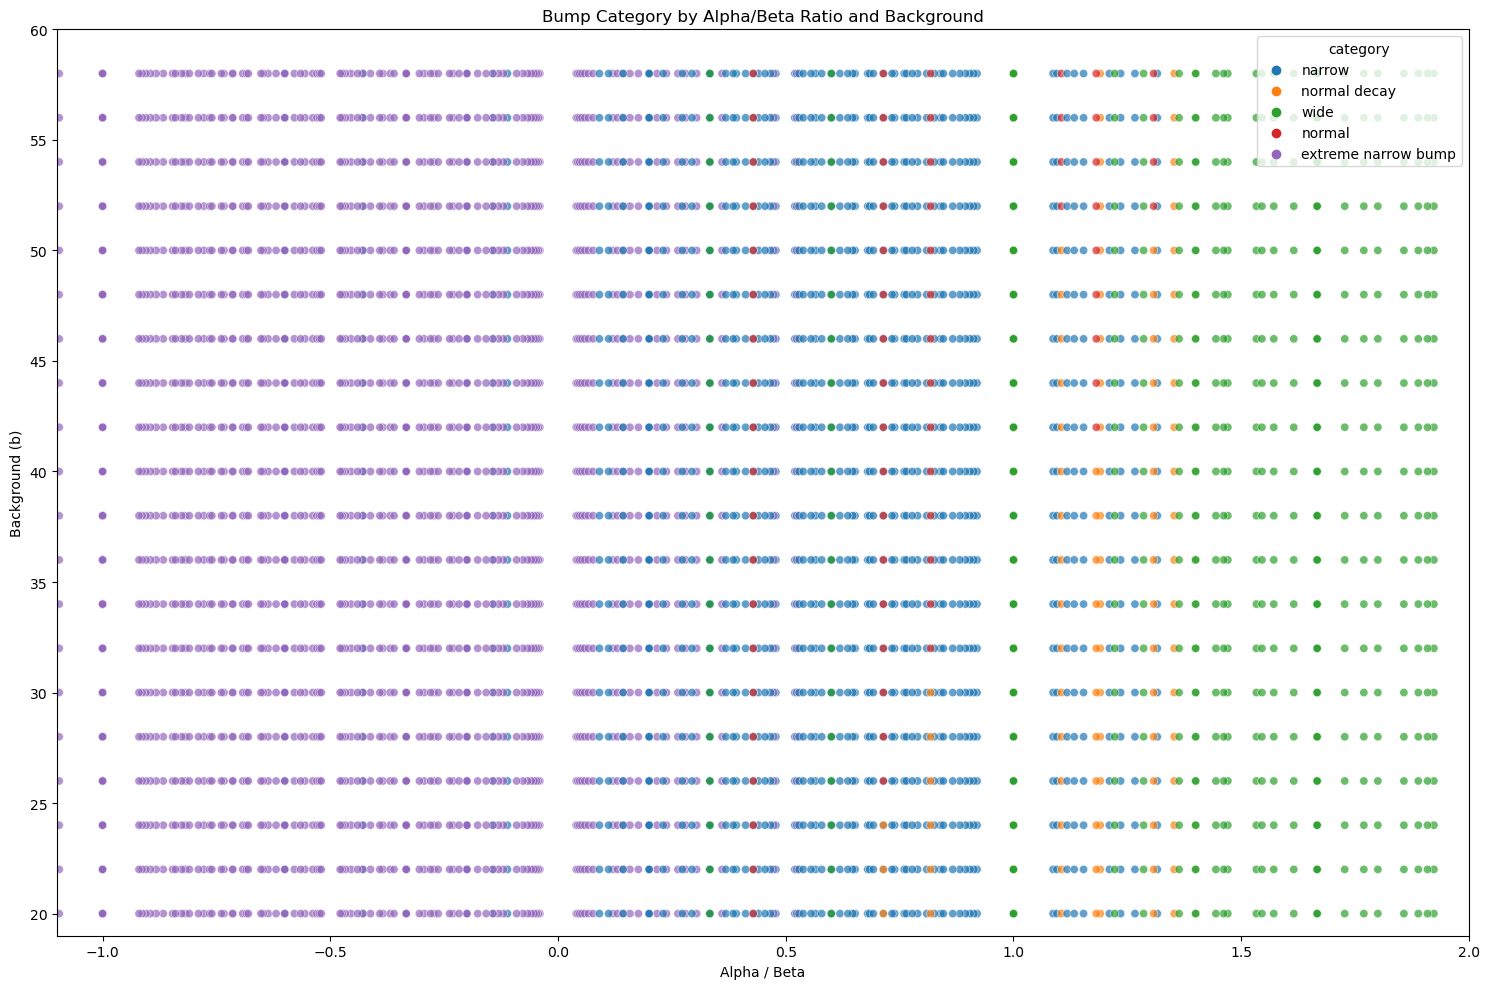

In [167]:
# Calculate the ratio alpha / beta, avoiding division by zero
df["alpha_beta_ratio"] = df["alpha"] / df["beta"].replace(0, float("nan"))

# Plotting: ratio vs. b colored by category
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x="alpha_beta_ratio", y="b", hue="category", alpha=0.7)
plt.xlabel("Alpha / Beta")
plt.ylabel("Background (b)")
plt.title("Bump Category by Alpha/Beta Ratio and Background")
plt.grid(False)
plt.xlim(-1.1,2)
plt.ylim(19,60)
plt.tight_layout()
plt.show()

In [147]:
df_normal = df[df['category'] == 'normal']
df_normal[df_normal['b'] == 20]

alpha  beta   b category  alpha_beta_ratio
4570     -3    -7  20   normal          0.428571

In [174]:
df_normal

alpha  beta   b category  alpha_beta_ratio
896     -21   -19  52   normal          1.105263
897     -21   -19  54   normal          1.105263
898     -21   -19  56   normal          1.105263
899     -21   -19  58   normal          1.105263
1766    -17   -13  52   normal          1.307692
...     ...   ...  ..      ...               ...
4585     -3    -7  50   normal          0.428571
4586     -3    -7  52   normal          0.428571
4587     -3    -7  54   normal          0.428571
4588     -3    -7  56   normal          0.428571
4589     -3    -7  58   normal          0.428571

[90 rows x 5 columns]

In [131]:
df_normal = df[df['category'] == 'normal decay']
df_normal

alpha  beta   b      category  alpha_beta_ratio
61      -25   -21   2  normal decay          1.190476
62      -25   -21   4  normal decay          1.190476
63      -25   -21   6  normal decay          1.190476
64      -25   -21   8  normal decay          1.190476
65      -25   -21  10  normal decay          1.190476
...     ...   ...  ..           ...               ...
4565     -3    -7  10  normal decay          0.428571
4566     -3    -7  12  normal decay          0.428571
4567     -3    -7  14  normal decay          0.428571
4568     -3    -7  16  normal decay          0.428571
4569     -3    -7  18  normal decay          0.428571

[200 rows x 5 columns]